# بسم الله الرحمن الرحيم

# 📦 Imports



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# 1. 🧹 Load Data

In [16]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# 🎯 Save target & ID


In [17]:
y = np.log1p(train["SalePrice"])  # log1p handles log(0) better
train_ID = train["Id"]
test_ID = test["Id"]

# 🧹 Drop ID and target

In [18]:
train.drop(["Id", "SalePrice"], axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

# 2. 🛠️ Preprocess

In [19]:
# 🔗 Combine train and test for preprocessing
all_data = pd.concat([train, test], axis=0)

# 🔧 Fill missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# 🧠 One-hot encoding
all_data = pd.get_dummies(all_data)

# 🚪 Split back into training and test sets
X = all_data.iloc[:len(y), :]
X_test = all_data.iloc[len(y):, :]

# 🔀 Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. 🤖 Train a Model



# 📊 XGBoost Regressor

In [20]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

# 🧠 Fit with early stopping


In [22]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# 4. 📉 Evaluate model


In [23]:
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.1128


# 🔍 Feature importance


<Figure size 1200x800 with 0 Axes>

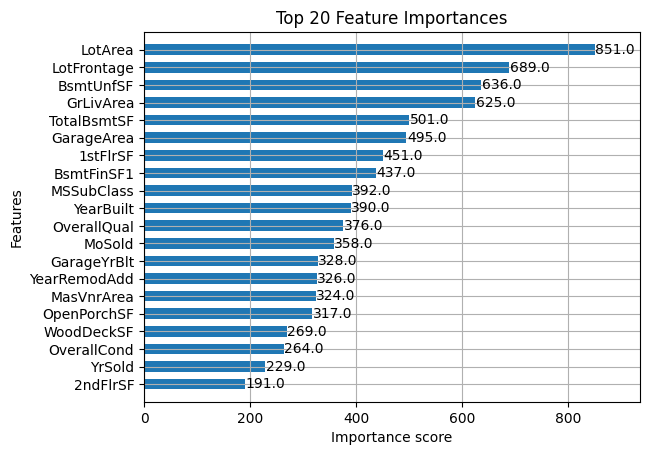

In [24]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20, height=0.6)
plt.title("Top 20 Feature Importances")
plt.show()


# 5. 🔮 Predict and Save Submission

In [25]:
test_preds = np.expm1(model.predict(X_test))  # inverse log1p


submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": test_preds
})
submission.to_csv("submission.csv", index=False)